#### libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.style.use('default')

import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
#%matplotlib widget

import utils as u

---

# Data

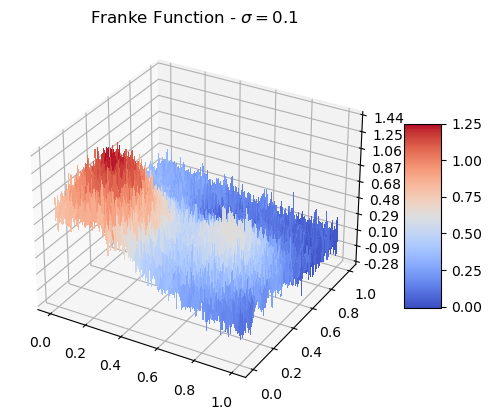

In [2]:
# settings
N = 200
random_ax = False
noise_scale = 0.1
scaling = False

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data. Use alternatively the uniform distribution
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# Plot the surface.
surf = ax.plot_surface(xm, ym, zm, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title(f"Franke Function - $\sigma=${noise_scale}")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
fig.savefig(r"/Users/daniekru/Documents/Learning/courses/compML/media/franke_function_noisy.png")
print("saved!")

# (a) Ordinary Least Square

**Model**

In [87]:
_ = u.get_coefficients(nb_vars=2, degree=3, verbose=True)

(len: 9) | form z = x^0*y^1 + x^1*y^0 + x^0*y^2 + x^1*y^1 + x^2*y^0 + x^0*y^3 + x^1*y^2 + x^2*y^1 + x^3*y^0 

SETTINGS

In [2]:
# data
N = 200
random_ax = True
noise_scale = 0.05
scaling = True
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
degrees = range(1, 20)
intercept = True

RUN

In [3]:
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': []}

betas = {}

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.2)

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    bar.set_description(f"degree={deg}")

    # define design matrix
    D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, Y=y_test, degree=deg, intercept=intercept)
        
    # train OLS
    beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[D_train, D_test], 
                                                                             dataset_z=[Z_train, Z_test])
        
    # record
    record['mse_train'] += [mse_train]
    record['cod_train'] += [cod_train]
    record['mse_test'] += [mse_test]
    record['cod_test'] += [cod_test]
    betas[deg] = beta
    
print('.')

degree=19: 100%|███████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 107.30it/s]

.


### Plot results - OLS regression

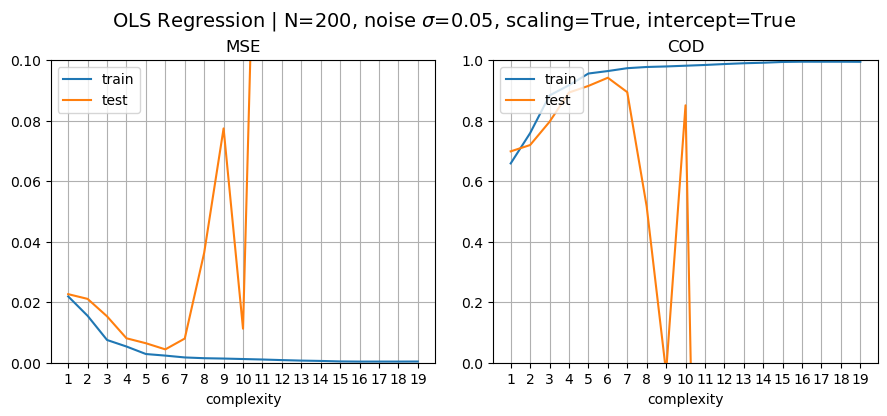

In [4]:
names = tuple(record.keys())
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f"OLS Regression | {N=}, noise $\sigma$={noise_scale}, {scaling=}, {intercept=}", fontsize=14)
fig.tight_layout(h_pad=4)

axs[0].plot(degrees, record['mse_train'], label='train')
axs[0].plot(degrees, record['mse_test'], label='test')
axs[0].set_title(f"MSE")
axs[0].set_xlabel('complexity')
axs[0].legend(loc='upper left')
axs[0].set_xticks(degrees)
axs[0].grid()
axs[0].set_ylim((0, 0.1))  # y-axis limits

axs[1].plot(degrees, record['cod_train'], label='train')
axs[1].plot(degrees, record['cod_test'], label='test')
axs[1].set_title(f"COD")
axs[1].set_xlabel('complexity')
axs[1].legend(loc='upper left')
axs[1].set_xticks(degrees)
axs[1].set_ylim((0, 1))
axs[1].grid()

plt.show()

### 3D plot and predictions

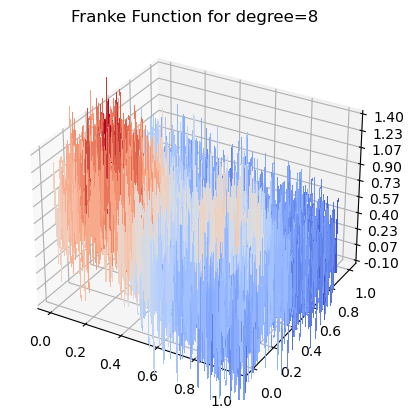

In [13]:
degree = 8

fig = plt.figure()
ax = fig.gca(projection='3d')

D = u.build_design_matrix(X=xm, Y=ym, degree=degree)
pred = (D @ betas[degree]).squeeze()

# Plot the surface.
surf = ax.plot_surface(xm, ym, zm, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf2 = ax.plot_surface(xm, ym, pred, cmap='Greys', linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title(f"Franke Function for {degree=}")

plt.show()

---

### Averaged

SETTINGS

In [26]:
# data
N = 200
random_ax = True
noise_scale = 2e-1
scaling = False
mean_centering = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling, mean_center=mean_centering)

# model
degrees = range(1, 11)
intercept = True

nb_iter = 3000

RUN

In [32]:
# general record initialization
record = {'avg_train_mse': [],
          'avg_test_mse': [],
          'avg_train_cod': [],
          'avg_test_cod': []}

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    bar.set_description(f"degree={deg}")
    
    # define design matrix
    D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg), u.build_design_matrix(X=x_test, Y=y_test, 
                                                                                                     degree=deg, intercept=intercept)
    
    # record initialization
    avg_train_mse = []
    avg_test_mse = []
    avg_train_cod = []
    avg_test_cod = []
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # iterate $nb_iter times
    for i_ter in range(nb_iter):

        Z_test = Z_test.reshape(-1, 1)

        # train OLS 
        _, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[D_train, D_test], 
                                                                    dataset_z=[Z_train, Z_test])

        # record
        avg_train_mse += [mse_train]
        avg_test_mse += [mse_test]
        avg_train_cod += [cod_train]
        avg_test_cod += [cod_test]
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
    
    # general record
    record['avg_train_mse'] += [np.mean(avg_train_mse)]
    record['avg_test_mse'] += [np.mean(avg_test_mse)]
    record['avg_train_cod'] += [np.mean(avg_train_cod)]
    record['avg_test_cod'] += [np.mean(avg_test_cod)]

print('.')

degree=10: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]

.


### Plot results - OLS regression

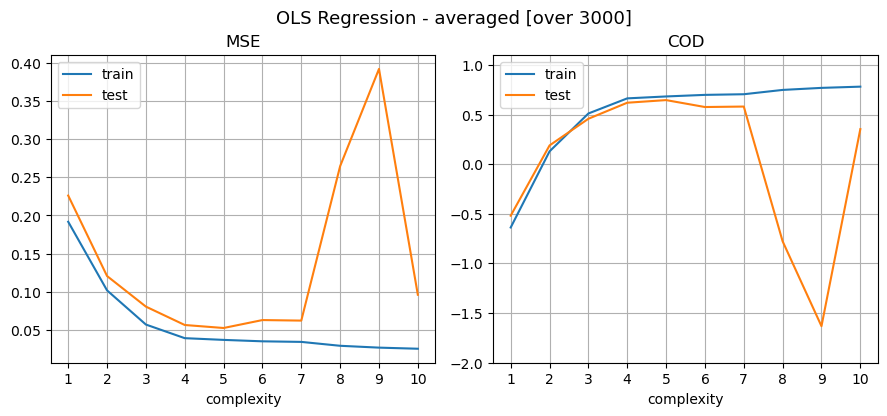

In [30]:
names = tuple(record.keys())
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f"OLS Regression - averaged [over {nb_iter}]", 
             fontsize=13)
fig.tight_layout(h_pad=1)

axs[0].plot(degrees, record['avg_train_mse'], label='train')
axs[0].plot(degrees, record['avg_test_mse'], label='test')
axs[0].set_title(f"MSE")
axs[0].set_xlabel('complexity')
axs[0].legend(loc='upper left')
axs[0].set_xticks(degrees)
axs[0].grid()
#axs[0].set_ylim((0, 0.4))  # y-axis limits

axs[1].plot(degrees, record['avg_train_cod'], label='train')
axs[1].plot(degrees, record['avg_test_cod'], label='test')
axs[1].set_title(f"COD")
axs[1].set_xlabel('complexity')
axs[1].legend(loc='upper left')
axs[1].set_xticks(degrees)
axs[1].set_ylim((-2, 1.1))  # y-axis limits
axs[1].grid()

#txt = f"{N=}, noise $\sigma$={noise_scale}, {scaling=}, {intercept=} - average={nb_iter}"

#fig.text(0.5, 0., txt, wrap=True, ha="center")

plt.show()

# (b) Bootstrap

---

### single run

SETTINGS

In [32]:
# data
N = 200
random_ax = True
noise_scale = 0.0
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
degrees = range(1, 20)
nb_bootstraps = 100

RUN

In [33]:
# prepare record
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mean_mse_train': [],
          'mean_cod_train': [],
          'mean_mse_test': [],
          'mean_cod_test': [],
          'model_bias': [],
          'model_var': [],
          'model_mse': []}

betas = {}

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    # define design matrix
    D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg), u.build_design_matrix(X=x_test, Y=y_test, degree=deg)
        
    len_train = len(x_train)
    list_len_train = list(range(len_train))
    
    # record
    mse_train_boot = []
    mse_test_boot = []
    cod_train_boot = []
    cod_test_boot = []
    betas_boot = []
    predictions_boot = []
    
    bias_boot = []
    var_boot = []
    mse_boot = []
    
    #Z_test = Z_test.reshape(-1, 1)

    pred_boots = np.empty((Z_test.shape[0], nb_bootstraps))
    
    # loop bootstrap iterations
    for i_boot in range(nb_bootstraps):

        # define new sampled training set
        indexes = np.random.choice(list_len_train, p=np.ones(len_train)/len_train, replace=True, size=len_train)
        D_train_resampled = D_train[indexes]
        Z_train_resampled = Z_train[indexes]
        
        # train OLS with resampled data
        beta, [mse_train, mse_test], [cod_train, cod_test], Z_pred_test = u.rOLS(\
                                                                            dataset_x=[D_train_resampled, D_test], 
                                                                            dataset_z=[Z_train_resampled, Z_test])
        
        # record <-
        pred_boots[:, i_boot] = Z_pred_test.flatten()
    
        
        # record bootstrap results 
        mse_train_boot += [mse_train]
        mse_test_boot += [mse_test]
        cod_train_boot += [cod_train]
        cod_test_boot += [cod_test]
        betas_boot += [beta]
        predictions_boot += [Z_pred_test.squeeze().tolist()]
        
        # 
        #mse_boot += [u.MSE(Z_true=Z_test, Z_pred=Z_pred_test).item()]
        #bias_boot += [((Z_test - np.mean(Z_pred_test))**2).mean()] 
        #var_boot += [np.var(Z_pred_test).item()]
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record degree result
    record['mse_train'] += [mse_train_boot]
    record['cod_train'] += [cod_train_boot]
    record['mse_test'] += [mse_test_boot]
    record['cod_test'] += [cod_test_boot]
    
    # average over bootstrap sessions
    record['mean_mse_train'] += [np.mean(mse_train_boot)]
    record['mean_cod_train'] += [np.mean(cod_train_boot)]
    record['mean_mse_test'] += [np.mean(mse_test_boot)]
    record['mean_cod_test'] += [np.mean(cod_test_boot)]
    
    # bias-variance
    predictions_boot = np.array(predictions_boot)
    #Z_test = Z_test[:, np.newaxis]
    
    #print(Z_test.shape, predictions_boot.shape)
    
    # ((N, 1) - <(N, n_boot)>)^2 -> ((N, 1)) - (N, 1))^2
    
    
    record['model_mse'] += [np.mean( np.mean((Z_test - pred_boots)**2, axis=1, keepdims=True) )]
    record['model_bias'] += [np.mean( (Z_test - np.mean(pred_boots, axis=1, keepdims=True))**2 )]
    record['model_var'] += [np.mean( np.var(pred_boots, axis=1, keepdims=True) )]
    
    #record['model_bias'] += [np.mean((Z_test.reshape(-1, 1) - predictions_boot.mean(axis=0, keepdims=True).T)**2)] 
    #record['model_var'] += [np.mean(predictions_boot.var(axis=1, keepdims=True))]
    #record['model_bias'] += [np.mean(bias_boot)]
    #record['model_var'] += [np.mean(var_boot)]
    #record['model_mse'] += [np.mean(mse_boot)]
    
    #record['model_bias'] += [u.MSE(Z_true=Z_test, Z_pred=np.ones((Z_test.shape[0], 1))*np.mean(np.mean(predictions_boot, axis=0, keepdims=True)))]
    #record['model_var'] += [np.mean(np.mean((predictions_boot - np.mean(predictions_boot, axis=1, keepdims=True))**2, axis=1))]

    betas[deg] = [beta]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.07s/it]

.


### plots

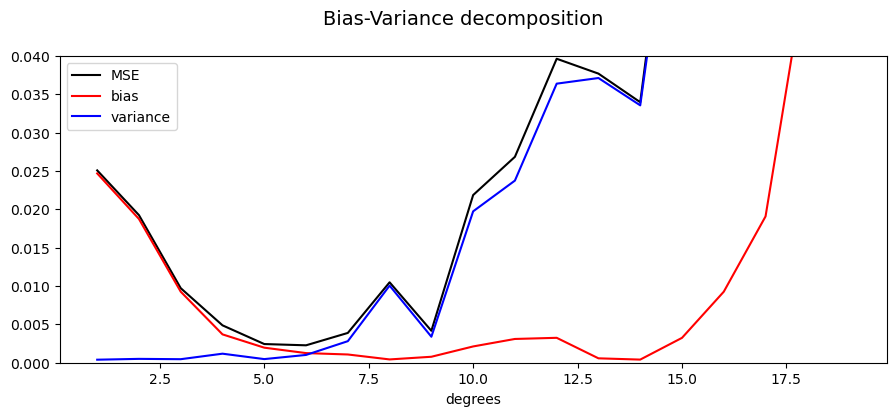

In [38]:
alpha = 0.2

# colors
colors = plt.cm.jet(np.linspace(0, 1, nb_bootstraps))

# figure
fig, ax = plt.subplots(1, 1, figsize=(9, 4), sharex=True)
fig.suptitle('Bias-Variance decomposition', fontsize=14)
fig.tight_layout(h_pad=2)

ax.plot(degrees, record['mean_mse_test'], '-k', label='MSE')
ax.plot(degrees, record['model_bias'], '-r', label='bias')
ax.plot(degrees, record['model_var'], '-b', label='variance')

ax.set_xlabel("degrees")
ax.legend(loc="upper left")

ax.set_ylim((0, .04))
plt.show()

---

In [126]:
# prepare record
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mean_mse_train': [],
          'mean_cod_train': [],
          'mean_mse_test': [],
          'mean_cod_test': [],
          'model_bias': [],
          'model_var': [],
          'model_mse': []}

betas = {}

# split data
X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    # define design matrix
    D = u.build_design_matrix(X=x, Y=y, degree=deg)
        
    len_train = len(X_train)
    list_len_train = list(range(len_train))
    
    # record
    mse_train_boot = []
    mse_test_boot = []
    cod_train_boot = []
    cod_test_boot = []
    betas_boot = []
    predictions_boot = []
    
    bias_boot = []
    var_boot = []
    mse_boot = []
    
    # loop bootstrap iterations
    for i_boot in range(nb_bootstraps):

        # define new sampled training set
        indexes = np.random.choice(list_len_train, p=np.ones(len_train)/len_train, replace=True, size=len_train)
        X_train_resampled = X_train[indexes]
        Z_train_resampled = Z_train[indexes]

        # train OLS with resampled data
        beta, [mse_train, mse_test], [cod_train, cod_test], Z_pred_test = u.rOLS(\
                                                                            dataset_x=[X_train_resampled, X_test], 
                                                                            dataset_z=[Z_train_resampled, Z_test])
    
        
        # record bootstrap results 
        mse_train_boot += [mse_train]
        mse_test_boot += [mse_test]
        cod_train_boot += [cod_train]
        cod_test_boot += [cod_test]
        betas_boot += [beta]
        predictions_boot += [Z_pred_test.squeeze().tolist()]
        
        # 
        #mse_boot += [u.MSE(Z_true=Z_test, Z_pred=Z_pred_test).item()]
        #bias_boot += [((Z_test - np.mean(Z_pred_test))**2).mean()] 
        #var_boot += [np.var(Z_pred_test).item()]
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record degree result
    record['mse_train'] += [mse_train_boot]
    record['cod_train'] += [cod_train_boot]
    record['mse_test'] += [mse_test_boot]
    record['cod_test'] += [cod_test_boot]
    
    # average over bootstrap sessions
    record['mean_mse_train'] += [np.mean(mse_train_boot)]
    record['mean_cod_train'] += [np.mean(cod_train_boot)]
    record['mean_mse_test'] += [np.mean(mse_test_boot)]
    record['mean_cod_test'] += [np.mean(cod_test_boot)]
    
    # bias-variance
    predictions_boot = np.array(predictions_boot)
    Z_test = Z_test[:, np.newaxis]
    
    #print(Z_test.shape, predictions_boot.shape)
    
    # ((N, 1) - <(N, n_boot)>)^2 -> ((N, 1)) - (N, 1))^2
    
    record['model_bias'] += [np.mean((Z_test.reshape(-1, 1) - predictions_boot.mean(axis=0, keepdims=True).T)**2)] 
    record['model_var'] += [np.mean(predictions_boot.var(axis=1, keepdims=True))]
    #record['model_bias'] += [np.mean(bias_boot)]
    #record['model_var'] += [np.mean(var_boot)]
    #record['model_mse'] += [np.mean(mse_boot)]
    
    #record['model_bias'] += [u.MSE(Z_true=Z_test, Z_pred=np.ones((Z_test.shape[0], 1))*np.mean(np.mean(predictions_boot, axis=0, keepdims=True)))]
    #record['model_var'] += [np.mean(np.mean((predictions_boot - np.mean(predictions_boot, axis=1, keepdims=True))**2, axis=1))]

    betas[deg] = [beta]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  2.93it/s]

.


In [154]:
Z_test.shape

(60, 1, 1)

### Plot results - OLS + Bootstrap

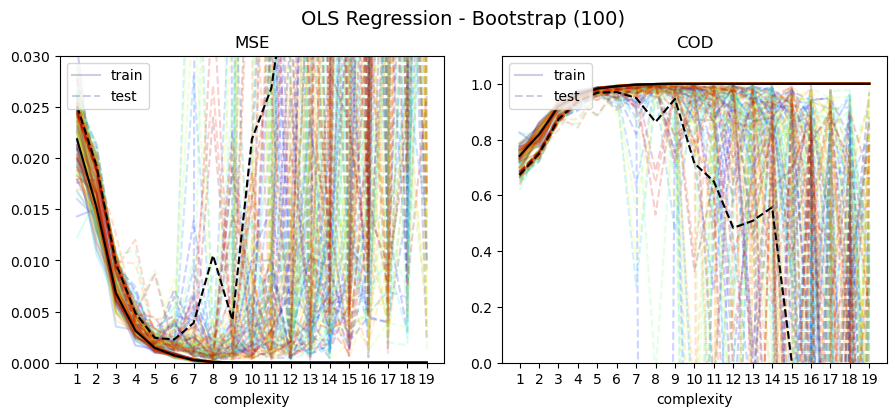

In [34]:
alpha = 0.2

# colors
colors = plt.cm.jet(np.linspace(0, 1, nb_bootstraps))

# figure
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f'OLS Regression - Bootstrap ({nb_bootstraps})', fontsize=14)
fig.tight_layout(h_pad=2)

for i in range(nb_bootstraps):
    axs[0].plot(degrees, record['mse_train'][:, i], '-', color=colors[i], alpha=alpha, label='train')
    axs[0].plot(degrees, record['mse_test'][:, i], '--', color=colors[i], alpha=alpha, label='test')
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    if i == 0: axs[0].legend(loc='upper left')
    axs[0].set_xticks(degrees)
    axs[0].grid()

    axs[1].plot(degrees, record['cod_train'][:, i], '-', color=colors[i], alpha=alpha, label='train')
    axs[1].plot(degrees, record['cod_test'][:, i], '--', color=colors[i], alpha=alpha, label='test')
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    if i == 0: axs[1].legend(loc='upper left')
    axs[1].set_xticks(degrees)
    axs[1].grid()
    

# mean     
axs[0].plot(degrees, record['mean_mse_train'], '-k', alpha=1, label='mean train')
axs[0].plot(degrees, record['mean_mse_test'], '--k', alpha=1, label='mean test')
axs[1].plot(degrees, record['mean_cod_train'], '-k', alpha=1, label='mean train')
axs[1].plot(degrees, record['mean_cod_test'], '--k', alpha=1, label='mean test')
if i == (nb_bootstraps + 1): axs[0].legend(loc='upper left')
if i == (nb_bootstraps + 1): axs[1].legend(loc='upper left')

axs[0].set_ylim(0, 0.03)
axs[1].set_ylim(0, 1.1)

plt.show()

### Plot - Bias & Variance

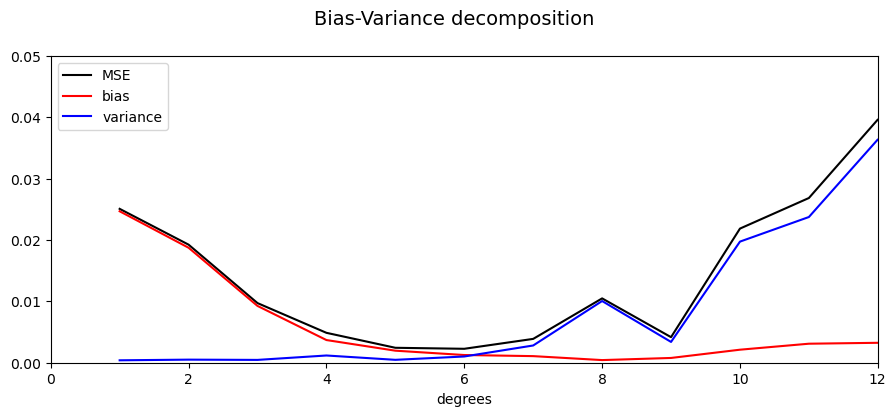

In [37]:
alpha = 0.2

# colors
colors = plt.cm.jet(np.linspace(0, 1, nb_bootstraps))

# figure
fig, ax = plt.subplots(1, 1, figsize=(9, 4), sharex=True)
fig.suptitle('Bias-Variance decomposition', fontsize=14)
fig.tight_layout(h_pad=2)

ax.plot(degrees, record['mean_mse_test'], '-k', label='MSE')
ax.plot(degrees, record['model_bias'], '-r', label='bias')
ax.plot(degrees, record['model_var'], '-b', label='variance')

ax.set_xlabel("degrees")
ax.legend(loc="upper left")

ax.set_ylim((0, .05))
ax.set_xlim((0, 12))
plt.show()

### averaged

SETTINGS

In [9]:
nb_iter = 100

degrees = range(1, 11)
nb_bootstraps = 100

(x, y, z), (xm, ym, zm) = u.generate_data(N=300, random_ax=False, noise_scale=0.)

RUN

In [10]:
# general record initialization
record = {'avg_test_mse': [],
          'avg_bias': [],
          'avg_var': []}

# run for all degrees
for deg in (bar := tqdm(degrees)):

    # define design matrix
    D = u.build_design_matrix(X=x, Y=y, degree=deg)

    # split data
    X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

    len_train = len(X_train)
    list_len_train = list(range(len_train))
    
    # record initialization
    avg_test_mse = []
    avg_bias = []
    avg_var = []
    
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # iterate $nb_iter times
    for i_ter in range(nb_iter):

        # record
        mse_train_boot = []
        mse_test_boot = []
        cod_train_boot = []
        cod_test_boot = []
        betas_boot = []
        predictions_boot = []
        
        Z_test = Z_test.reshape(-1, 1)

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

        # loop bootstrap iterations
        for i_boot in range(nb_bootstraps):

            # define new sampled training set
            indexes = np.random.choice(list_len_train, p=np.ones(len_train)/len_train, replace=True, size=len_train)
            X_train_resampled = X_train[indexes]
            Z_train_resampled = Z_train[indexes]

            # train OLS with resampled data
            beta, [mse_train, mse_test], [cod_train, cod_test], Z_pred_test = u.rOLS(\
                                                                                dataset_x=[X_train_resampled, X_test], 
                                                                                dataset_z=[Z_train_resampled, Z_test])


            # record bootstrap results 
            mse_train_boot += [mse_train]
            mse_test_boot += [mse_test]
            cod_train_boot += [cod_train]
            cod_test_boot += [cod_test]
            betas_boot += [beta]
            predictions_boot += [Z_pred_test.squeeze().tolist()]

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

        # bias-variance
        predictions_boot = np.array(predictions_boot)
        Z_test = Z_test[:, np.newaxis]

        # record
        avg_test_mse += [np.mean(mse_test_boot)]
        avg_bias += [np.mean((Z_test.reshape(-1, 1) - predictions_boot.mean(axis=0, keepdims=True).T)**2)] 
        avg_var += [np.mean(predictions_boot.var(axis=1, keepdims=True))]
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
    
    # general record
    record['avg_test_mse'] += [np.mean(avg_test_mse)]
    record['avg_bias'] += [np.mean(avg_bias)]
    record['avg_var'] += [np.mean(avg_var)]


print('.')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.34s/it]

.


### plot

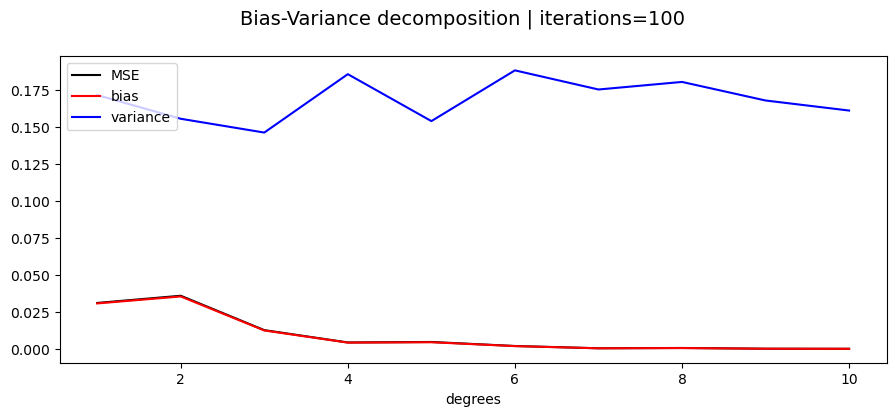

In [23]:
alpha = 0.2

# colors
colors = plt.cm.jet(np.linspace(0, 1, nb_bootstraps))

# figure
fig, ax = plt.subplots(1, 1, figsize=(9, 4), sharex=True)
fig.suptitle(f"Bias-Variance decomposition | iterations={nb_iter}", fontsize=14)
fig.tight_layout(h_pad=2)

ax.plot(degrees, record['avg_test_mse'], '-k', label='MSE')
ax.plot(degrees, record['avg_bias'], '-r', label='bias')
ax.plot(degrees, record['avg_var'], '-b', label='variance')

ax.set_xlabel("degrees")
ax.legend(loc="upper left")

#ax.set_ylim((0, .1))
plt.show()

---

# (c) Cross-validation

DATA

In [21]:
(x, y, z), (xm, ym, zm) = u.generate_data(N=250, random_ax=True, noise_scale=0.05)

SETTINGS

In [22]:
nb_folds = 10
fold_source = 'sklearn'

# Design matrix
degrees = range(1, 15)

RUN

In [23]:
# prepare record
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mean_mse_train': [],
          'mean_cod_train': [],
          'mean_mse_test': [],
          'mean_cod_test': [],
          'model_bias': [],
          'model_var': []}

betas = {}

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    # define design matrix
    D = u.build_design_matrix(X=x, Y=y, degree=deg)
    
    # record
    mse_train_folds = []
    mse_test_folds = []
    cod_train_folds = []
    cod_test_folds = []
    betas_folds = []
    predictions_folds = []
    
    #
    if fold_source == "manual":
        fold_x, fold_z = u.manual_folding(dataset_x=D, dataset_z=z, K=nb_folds)
        
    elif fold_source == "sklearn":
        fold_x, fold_z = u.folding_from_sklearn(dataset_x=D, dataset_z=z, K=nb_folds)
        
    else:
        raise NameError(f"!{fold_source=} not implemented")
    
    # loop folds iterations
    for k in range(nb_folds):

        # obtain data folds
        X_train, X_test = fold_x[k]
        Z_train, Z_test = fold_z[k]
        
        # OLS run
        beta, [mse_train, mse_test], [cod_train, cod_test], Z_pred_test = u.rOLS(dataset_x=fold_x[k], 
                                                                                 dataset_z=fold_z[k])
        
        # record fold results
        mse_train_folds += [mse_train]
        mse_test_folds += [mse_test]
        cod_train_folds += [cod_train]
        cod_test_folds += [cod_test]
        betas_folds += [beta]
        predictions_folds += [Z_pred_test.squeeze().tolist()]
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record degree result
    record['mse_train'] += [mse_train_folds]
    record['cod_train'] += [cod_train_folds]
    record['mse_test'] += [mse_test_folds]
    record['cod_test'] += [cod_test_folds]
    
    # mean
    record['mean_mse_train'] += [np.mean(mse_train_folds)]
    record['mean_cod_train'] += [np.mean(cod_train_folds)]
    record['mean_mse_test'] += [np.mean(mse_test_folds)]
    record['mean_cod_test'] += [np.mean(cod_test_folds)]

    betas[deg] = [beta]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 67.31it/s]

.


### Plot results: OLS + K-Fold

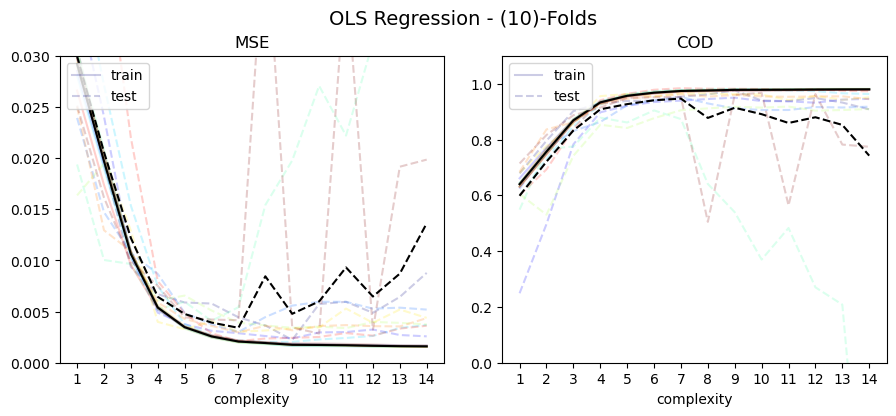

In [24]:
alpha = 0.2

# colors
colors = plt.cm.jet(np.linspace(0, 1, nb_folds))

# figure
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f'OLS Regression - ({nb_folds})-Folds', fontsize=14)
fig.tight_layout(h_pad=2)

for i in range(nb_folds):
    axs[0].plot(degrees, record['mse_train'][:, i], '-', color=colors[i], alpha=alpha, label='train')
    axs[0].plot(degrees, record['mse_test'][:, i], '--', color=colors[i], alpha=alpha, label='test')
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    if i == 0: axs[0].legend(loc='upper left')
    axs[0].set_xticks(degrees)
    axs[0].grid()

    axs[1].plot(degrees, record['cod_train'][:, i], '-', color=colors[i], alpha=alpha, label='train')
    axs[1].plot(degrees, record['cod_test'][:, i], '--', color=colors[i], alpha=alpha, label='test')
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    if i == 0: axs[1].legend(loc='upper left')
    axs[1].set_xticks(degrees)
    axs[1].grid()
    

# mean     
axs[0].plot(degrees, record['mean_mse_train'], '-k', alpha=1, label='mean train')
axs[0].plot(degrees, record['mean_mse_test'], '--k', alpha=1, label='mean test')
axs[1].plot(degrees, record['mean_cod_train'], '-k', alpha=1, label='mean train')
axs[1].plot(degrees, record['mean_cod_test'], '--k', alpha=1, label='mean test')
if i == (nb_bootstraps + 1): axs[0].legend(loc='upper left')
if i == (nb_bootstraps + 1): axs[1].legend(loc='upper left')

axs[0].set_ylim(0, 0.03)
axs[1].set_ylim(0, 1.1)

plt.show()

---

# (d) Ridge regularization

### single run

DATA

In [4]:
(x, y, z), (xm, ym, zm) = u.generate_data(N=100, random_ax=False, noise_scale=0.2)

SETTINGS

In [5]:
nb_lambdas = 100
lambdas = np.linspace(0, 2, nb_lambdas)
degrees = range(1, 9)

RUN

In [89]:
# prepare record
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mean_mse_train': [],
          'mean_cod_train': [],
          'mean_mse_test': [],
          'mean_cod_test': []}

betas = {}

# iterate over different lambda values
for lmd in tqdm(lambdas):
    
    # record
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    # run for all degrees
    for deg in degrees:

        # define design matrix
        D = u.build_design_matrix(X=x, Y=y, degree=deg)

        # split data
        X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

        # OLS run
        beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[X_train, X_test], 
                                                                       dataset_z=[Z_train, Z_test],
                                                                       ridge=True, 
                                                                       lambda_r=lmd)

        # record degree results
        mse_train_lambdas += [mse_train]
        mse_test_lambdas += [mse_test]
        cod_train_lambdas += [cod_train]
        cod_test_lambdas += [cod_test]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

100%|██████████████████████████████████████████| 75/75 [00:00<00:00, 116.44it/s]

.


#### Plot results: OLS + Ridge

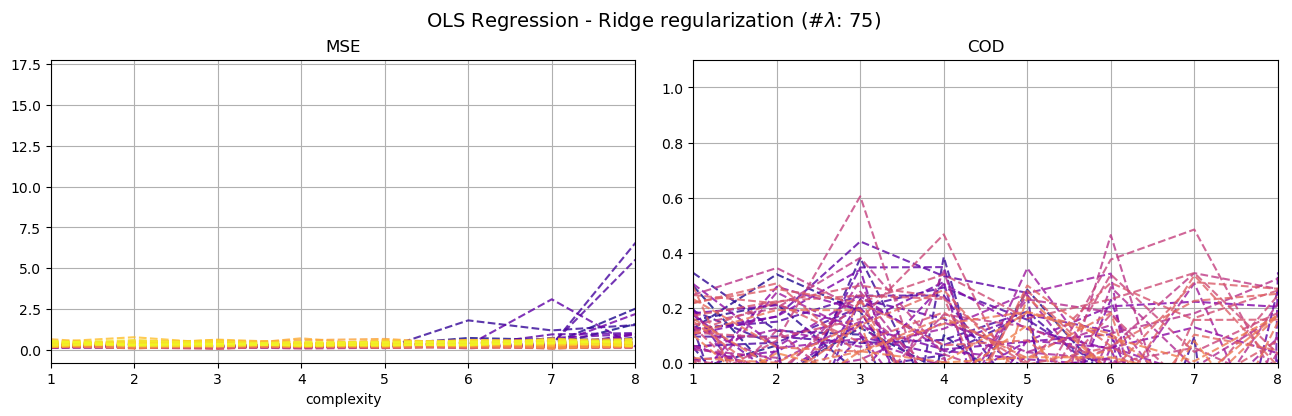

In [90]:
alpha = 0.8

# colors
colors = plt.cm.plasma(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(13, 4), sharex=True)
fig.suptitle(f'OLS Regression - Ridge regularization (#$\lambda$: {nb_lambdas})', fontsize=14)
fig.tight_layout(h_pad=2)

for i, l in enumerate(lambdas):
    #axs[0].plot(degrees, record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[0].plot(degrees, record['mse_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    #axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    #axs[1].plot(degrees, record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[1].plot(degrees, record['cod_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    #axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()

#axs[0].set_ylim(0, 0.06)
axs[1].set_ylim(0, 1.1)

axs[0].set_xlim(1, 8)
axs[1].set_xlim(1, 8)
plt.show()

### averaged runs

DATA

In [4]:
N = 100
random_ax = True
noise_scale = 0.7
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale)

SETTINGS

In [5]:
n_iter = 20
nb_lambdas = 100
#lambdas = np.linspace(0, 1, nb_lambdas)
lambdas = np.logspace(-12, 7, nb_lambdas)
degrees = range(1, 11)

RUN

In [6]:
# prepare total record
tot_record = {'mse_train': [],
              'mse_test': [],
              'cod_train': [],
              'cod_test': []}

for k in tqdm(range(n_iter)):

    # prepare record
    record = {'mse_train': [],
              'mse_test': [],
              'cod_train': [],
              'cod_test': []}

    betas = {}

    # iterate over different lambda values
    for lmd in lambdas:

        # record
        mse_train_lambdas = []
        mse_test_lambdas = []
        cod_train_lambdas = []
        cod_test_lambdas = []

        # run for all degrees
        for deg in degrees:

            # define design matrix
            D = u.build_design_matrix(X=x, Y=y, degree=deg)

            # split data
            X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

            # OLS run
            beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[X_train, X_test], 
                                                                           dataset_z=[Z_train, Z_test],
                                                                           ridge=True, 
                                                                           lambda_r=lmd)

            # record degree results
            mse_train_lambdas += [mse_train]
            mse_test_lambdas += [mse_test]
            cod_train_lambdas += [cod_train]
            cod_test_lambdas += [cod_test]

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

        # record lambda result
        record['mse_train'] += [mse_train_lambdas]
        record['cod_train'] += [cod_train_lambdas]
        record['mse_test'] += [mse_test_lambdas]
        record['cod_test'] += [cod_test_lambdas]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
    
    # record iteration results
    tot_record['mse_train'] += [record['mse_train']]
    tot_record['cod_train'] += [record['cod_train']]
    tot_record['mse_test'] += [record['mse_test']]
    tot_record['cod_test'] += [record['cod_test']]
    
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

# convert to arrays and average
tot_record['mse_train'] = np.array(tot_record['mse_train']).mean(axis=0)
tot_record['cod_train'] = np.array(tot_record['cod_train']).mean(axis=0) 
tot_record['mse_test'] = np.array(tot_record['mse_test']).mean(axis=0) 
tot_record['cod_test'] = np.array(tot_record['cod_test']).mean(axis=0)

print('.')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.00s/it]

.


#### Plot results

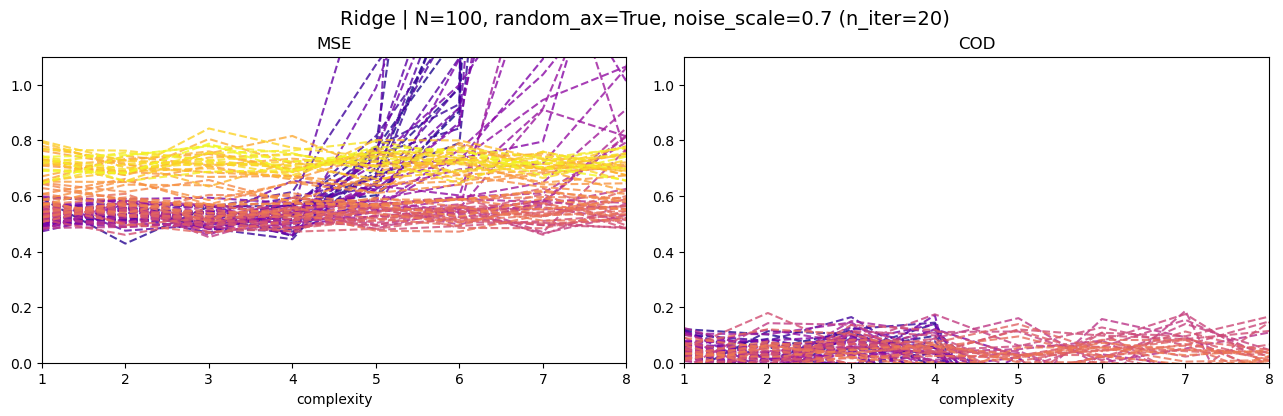

In [104]:
alpha = 0.8

# colors
colors = plt.cm.plasma(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(13, 4), sharex=True)
fig.suptitle(f'Ridge | {N=}, {random_ax=}, {noise_scale=} ({n_iter=})', fontsize=14)
fig.tight_layout(h_pad=2)

for i, l in enumerate(lambdas):
    #axs[0].plot(degrees, tot_record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[0].plot(degrees, tot_record['mse_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    #axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    #axs[1].plot(degrees, tot_record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[1].plot(degrees, tot_record['cod_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    #axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()

axs[0].set_ylim(0., 1.1)
axs[1].set_ylim(0, 1.1)

axs[0].set_xlim(1, 8)
axs[1].set_xlim(1, 8)
plt.show()

### Heatmap

In [238]:
from matplotlib import colors as plt_colors

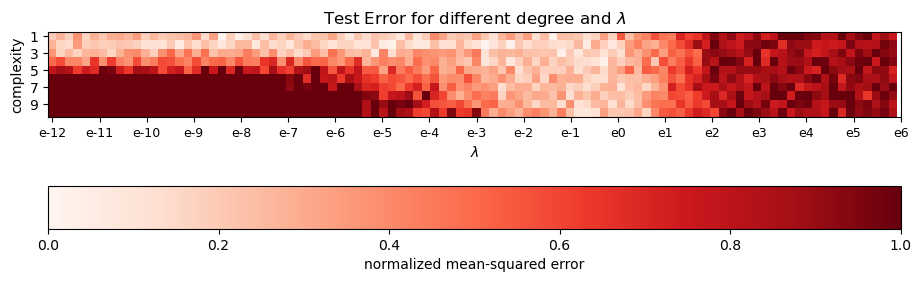

In [85]:
data_to_plot = np.clip(tot_record['mse_test'], 0, 1).T

fig, ax = plt.subplots(figsize=(11, 6))
cmap = cm.get_cmap("Reds")
#norm = plt_colors.Normalize(0, data_to_plot.max())

ax.set_title(f"Ridge - Test Error for different degree and $\lambda$")

ax.imshow(np.clip(tot_record['mse_test'], 0, 1).T, cmap=cmap)

ax.set_ylabel('complexity')
ax.set_xlabel('$\lambda$')

# plot colorbar
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location="bottom", label="normalized mean-squared error")

#fig.colorbar(pos, ax)
lambdas_labels = [f"e{i}" for i in range(-12, 7)]
ax.set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
ax.set_xticklabels(lambdas_labels, fontsize=9)
ax.set_yticks(range(0, len(degrees), 2))
ax.set_yticklabels(range(1, 11, 2))
plt.show()

## Ridge + Boostrap

SETTINGS

In [30]:
nb_bootstraps = 100
nb_lambdas = 10
lambdas = np.linspace(0, 1, nb_lambdas)
degrees = range(1, 8)

RUN

In [31]:
# general prepare record init
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': []}

# iterate over different lambda values
for lmd in (bar_lmd := tqdm(lambdas)):
    
    bar_lmd.set_description(f"lambda={lmd:.2f}")
    
    # record degree init
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    # run for all degrees
    for deg in degrees:
        
        # define design matrix
        D = u.build_design_matrix(X=x, Y=y, degree=deg)

        # split data
        X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

        #
        len_train = len(X_train)
        list_len_train = list(range(len_train))

        # record bootstrap init
        mse_train_boot = []
        mse_test_boot = []
        cod_train_boot = []
        cod_test_boot = []
        betas_boot = []
        predictions_boot = []
        
        # loop bootstrap iterations
        for i_boot in range(nb_bootstraps):

            # define new sampled training set
            indexes = np.random.choice(list_len_train, p=np.ones(len_train)/len_train, \
                                       replace=True, size=len_train)
            X_train_resampled = X_train[indexes]
            Z_train_resampled = Z_train[indexes]

            # train OLS with resampled data
            _, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[X_train_resampled, X_test], 
                                                                        dataset_z=[Z_train_resampled, Z_test],
                                                                        ridge=True,
                                                                        lambda_r=lmd)


            # record bootstrap results
            mse_train_boot += [mse_train]
            mse_test_boot += [mse_test]
            cod_train_boot += [cod_train]
            cod_test_boot += [cod_test]
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #    
    
        # record degree results | average over bootstrap sessions
        mse_train_lambdas += [np.mean(mse_train_boot)]
        mse_test_lambdas += [np.mean(mse_test_boot)]
        cod_train_lambdas += [np.mean(cod_train_boot)]
        cod_test_lambdas += [np.mean(cod_test_boot)]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

lambda=1.00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.04it/s]

.


### Plot results: OLS + Ridge + Bootstrap

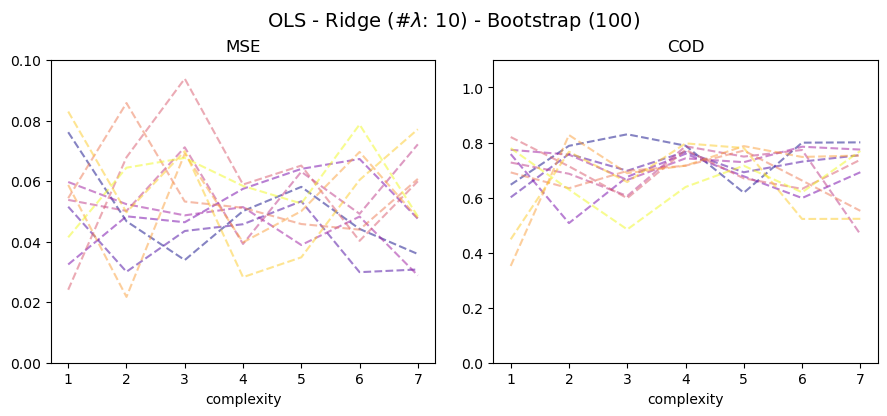

In [34]:
alpha = 0.5

# colors
colors = plt.cm.plasma(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f'OLS - Ridge (#$\lambda$: {nb_lambdas}) - Bootstrap ({nb_bootstraps})', fontsize=14)
fig.tight_layout(h_pad=2)

for i, l in enumerate(lambdas):
    #axs[0].plot(degrees, record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[0].plot(degrees, record['mse_test'][i, :], '--', color=colors[i], alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    #axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    #axs[1].plot(degrees, record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[1].plot(degrees, record['cod_test'][i, :], '--', color=colors[i], alpha=alpha)
    
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    #axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()

axs[0].set_ylim(0, 0.1)
axs[1].set_ylim(0, 1.1)
plt.show()

## Ridge + Cross-validation

SETTINGS

In [114]:
nb_folds = 10
nb_lambdas = 10
lambdas = np.linspace(0, 4, nb_lambdas)
degrees = range(1, 20)

RUN

In [115]:
# general prepare record init
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': []}

# iterate over different lambda values
for lmd in (bar_lmd := tqdm(lambdas)):
    
    bar_lmd.set_description(f"lambda={lmd:.2f}")
    
    # record degree init
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    # run for all degrees
    for deg in degrees:
        
        # define design matrix
        D = u.build_design_matrix(X=x, Y=y, degree=deg)
        
        # record KFold init
        mse_train_folds = []
        mse_test_folds = []
        cod_train_folds = []
        cod_test_folds = []
        betas_folds = []
        predictions_folds = []

        #
        if fold_source == "manual":
            fold_x, fold_z = u.manual_folding(dataset_x=D, dataset_z=z, K=nb_folds)

        elif fold_source == "sklearn":
            fold_x, fold_z = u.folding_from_sklearn(dataset_x=D, dataset_z=z, K=nb_folds)

        else:
            raise NameError(f"!{fold_source=} not implemented")

        # loop folds iterations
        for k in range(nb_folds):

            # OLS run
            _, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=fold_x[k], 
                                                                        dataset_z=fold_z[k],
                                                                        ridge=True,
                                                                        lambda_r=lmd)

            # record fold results
            mse_train_folds += [mse_train]
            mse_test_folds += [mse_test]
            cod_train_folds += [cod_train]
            cod_test_folds += [cod_test]
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #    
    
        # record degree results | average over bootstrap sessions
        mse_train_lambdas += [np.mean(mse_train_folds)]
        mse_test_lambdas += [np.mean(mse_test_folds)]
        cod_train_lambdas += [np.mean(cod_train_folds)]
        cod_test_lambdas += [np.mean(cod_test_folds)]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

lambda=4.00: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]

.


### Plot results: OLS + Ridge + Cross-validation

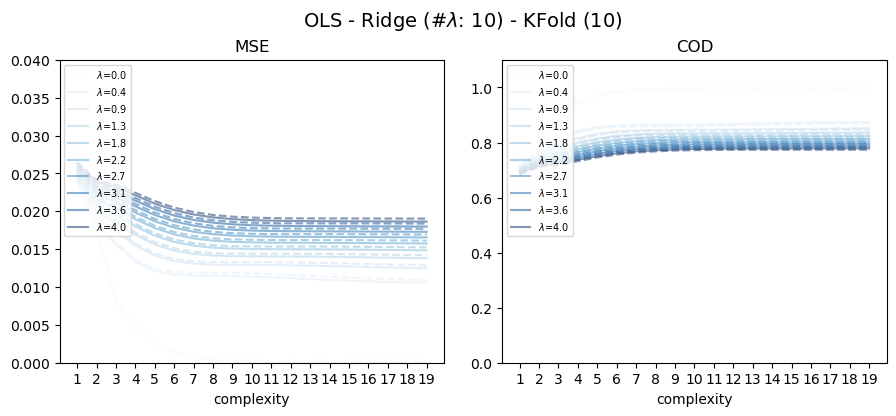

In [116]:
alpha = 0.5

# colors
colors = plt.cm.Blues(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f'OLS - Ridge (#$\lambda$: {nb_lambdas}) - KFold ({nb_folds})', fontsize=14)
fig.tight_layout(h_pad=2)

for i, l in enumerate(lambdas):
    axs[0].plot(degrees, record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[0].plot(degrees, record['mse_test'][i, :], '--', color=colors[i], alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    axs[1].plot(degrees, record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[1].plot(degrees, record['cod_test'][i, :], '--', color=colors[i], alpha=alpha)
    
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()

axs[0].set_ylim(0, 0.04)
axs[1].set_ylim(0, 1.1)
plt.show()

---

# (e) Lasso regularization

### single run

In [138]:
# prepare record
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mean_mse_train': [],
          'mean_cod_train': [],
          'mean_mse_test': [],
          'mean_cod_test': []}

betas = {}

# iterate over different lambda values
for lmd in tqdm(lambdas):
    
    # record
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    # run for all degrees
    for deg in degrees:

        # define design matrix
        D = u.build_design_matrix(X=x, Y=y, degree=deg)

        # split data
        X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

        # OLS run
        beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[X_train, X_test], 
                                                                       dataset_z=[Z_train, Z_test],
                                                                       lasso=True, 
                                                                       lambda_r=lmd)

        # record degree results
        mse_train_lambdas += [mse_train]
        mse_test_lambdas += [mse_test]
        cod_train_lambdas += [cod_train]
        cod_test_lambdas += [cod_test]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.59it/s]

.


#### Plot results

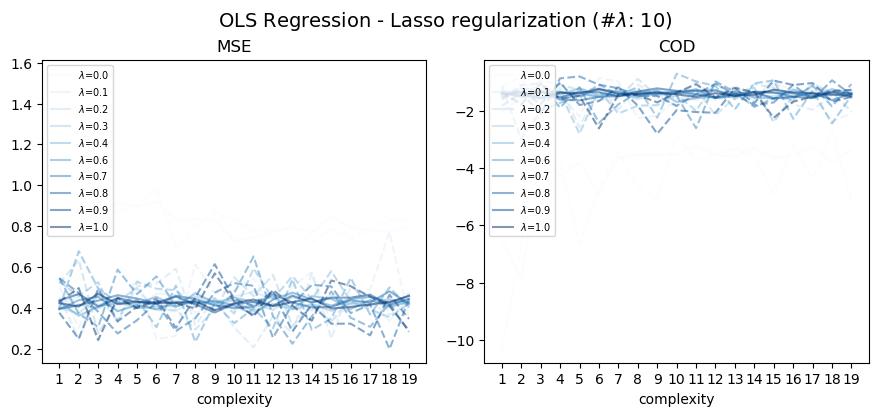

In [139]:
alpha = 0.5

# colors
colors = plt.cm.Blues(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f'OLS Regression - Lasso regularization (#$\lambda$: {nb_lambdas})', fontsize=14)
fig.tight_layout(h_pad=2)

for i, l in enumerate(lambdas):
    axs[0].plot(degrees, record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[0].plot(degrees, record['mse_test'][i, :], '--', color=colors[i], alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    axs[1].plot(degrees, record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[1].plot(degrees, record['cod_test'][i, :], '--', color=colors[i], alpha=alpha)
    
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()

#axs[0].set_ylim(0, 0.04)
#axs[1].set_ylim(0, 1.1)
plt.show()

### averaged runs

DATA

In [242]:
N = 150
random_ax = True
noise_scale = 0.01
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale)

SETTINGS

In [243]:
n_iter = 20
nb_lambdas = 100
lambdas = np.logspace(-12, 7, nb_lambdas)
#lambdas = np.linspace(0, 1, nb_lambdas)
degrees = range(1, 11)

RUN

In [244]:
# prepare total record
tot_record = {'mse_train': [],
              'mse_test': [],
              'cod_train': [],
              'cod_test': []}

for k in tqdm(range(n_iter)):

    # prepare record
    record = {'mse_train': [],
              'mse_test': [],
              'cod_train': [],
              'cod_test': []}

    betas = {}

    # iterate over different lambda values
    for lmd in lambdas:

        # record
        mse_train_lambdas = []
        mse_test_lambdas = []
        cod_train_lambdas = []
        cod_test_lambdas = []

        # run for all degrees
        for deg in degrees:

            # define design matrix
            D = u.build_design_matrix(X=x, Y=y, degree=deg)

            # split data
            X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

            # OLS run
            beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[X_train, X_test], 
                                                                           dataset_z=[Z_train, Z_test],
                                                                           lasso=True, 
                                                                           lambda_r=lmd)

            # record degree results
            mse_train_lambdas += [mse_train]
            mse_test_lambdas += [mse_test]
            cod_train_lambdas += [cod_train]
            cod_test_lambdas += [cod_test]

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

        # record lambda result
        record['mse_train'] += [mse_train_lambdas]
        record['cod_train'] += [cod_train_lambdas]
        record['mse_test'] += [mse_test_lambdas]
        record['cod_test'] += [cod_test_lambdas]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
    
    # record iteration results
    
    tot_record['mse_train'] += [record['mse_train']]
    tot_record['cod_train'] += [record['cod_train']]
    tot_record['mse_test'] += [record['mse_test']]
    tot_record['cod_test'] += [record['cod_test']]
    
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

# convert to arrays and average
tot_record['mse_train'] = np.array(tot_record['mse_train']).mean(axis=0)
tot_record['cod_train'] = np.array(tot_record['cod_train']).mean(axis=0) 
tot_record['mse_test'] = np.array(tot_record['mse_test']).mean(axis=0) 
tot_record['cod_test'] = np.array(tot_record['cod_test']).mean(axis=0)

print('.')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.03s/it]

.


#### Plot results

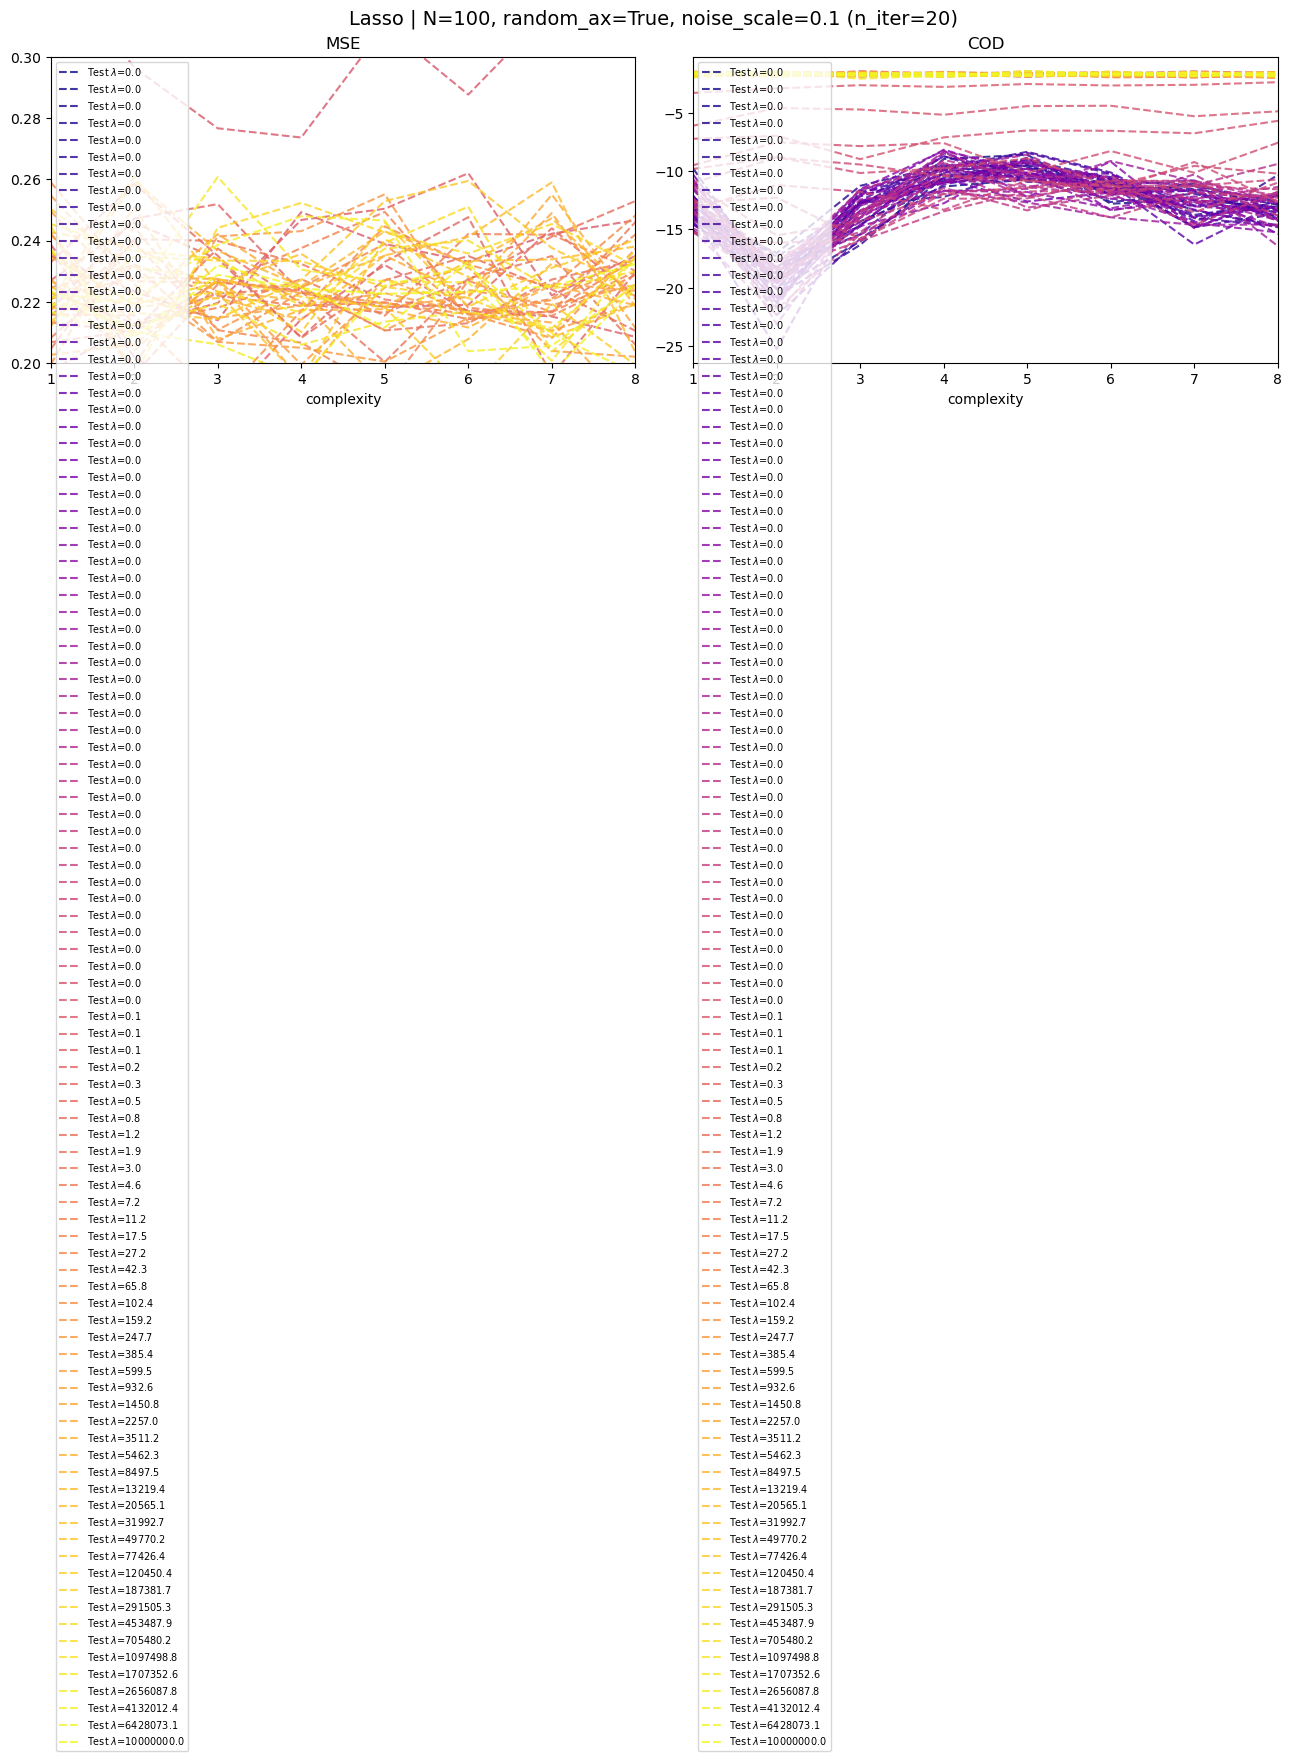

In [236]:
alpha = 0.8

# colors
colors = plt.cm.plasma(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(13, 4), sharex=True)
fig.suptitle(f'Lasso | {N=}, {random_ax=}, {noise_scale=} ({n_iter=})', fontsize=14)
fig.tight_layout(h_pad=2)

for i, l in enumerate(lambdas):
    #axs[0].plot(degrees, tot_record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[0].plot(degrees, tot_record['mse_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    #axs[1].plot(degrees, tot_record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[1].plot(degrees, tot_record['cod_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()

axs[0].set_ylim(0.2, 0.3)
#axs[1].set_ylim(0, 1.1)

axs[0].set_xlim(1, 8)
axs[1].set_xlim(1, 8)
plt.show()

#### Heatmap

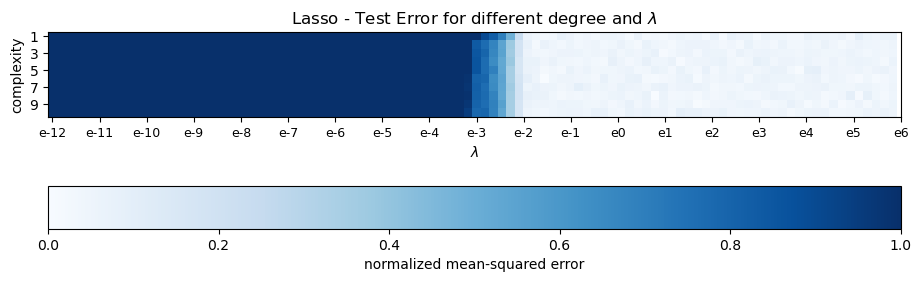

In [245]:
data_to_plot = np.clip(tot_record['mse_test'], 0, 1).T

fig, ax = plt.subplots(figsize=(11, 6))
cmap = cm.get_cmap("Blues")
norm = plt_colors.Normalize(0, data_to_plot.max())

ax.set_title(f"Lasso - Test Error for different degree and $\lambda$")

ax.imshow(np.clip(tot_record['mse_test'], 0, 1).T, cmap=cmap)

ax.set_ylabel('complexity')
ax.set_xlabel('$\lambda$')

# plot colorbar
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax, location="bottom", label="normalized mean-squared error")

#fig.colorbar(pos, ax)
lambdas_labels = [f"e{i}" for i in range(-12, 7)]
ax.set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
ax.set_xticklabels(lambdas_labels, fontsize=9)
ax.set_yticks(range(0, len(degrees), 2))
ax.set_yticklabels(range(1, 11, 2))
plt.show()

u.save_figure(fig=fig, name="lasso_LRfL", path="/Users/daniekru/Library/Mobile Documents/iCloud~md~obsidian/Documents/x404Proj/secondary/comp_ml_proj 1/media")

---

# (f) Stochastic Gradient Descent

## Polynomial Data

In [143]:
true_degree = 5
noise_scale = 0.01
true_beta = [0, 0.08, -0.017, 0.001]
x, z, true_beta = u.polynomial_data(degree=true_degree, 
                                    N=100, 
                                    true_beta=true_beta, 
                                    random_ax=True, 
                                    noise_scale=noise_scale,
                                    verbose=True)

true polynomial : z = (0.0000)*x^0 + (0.0800)*x^1 + (-0.0170)*x^2 + (0.0010)*x^3


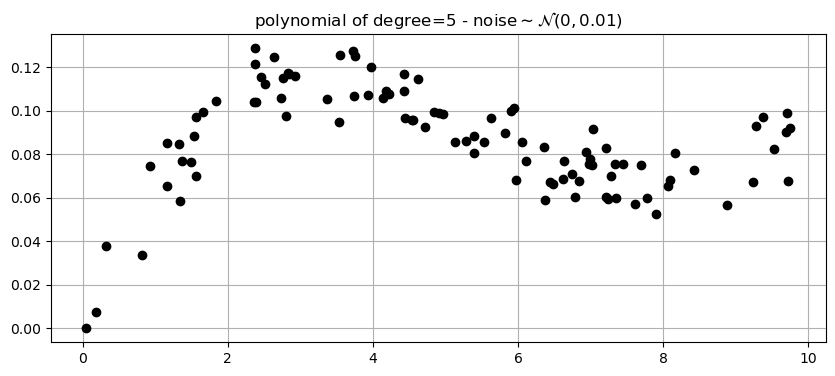

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(x, z, 'ok')
ax.set_title(f"polynomial of degree={true_degree} - noise" + "$\sim\mathcal{N}$" + f"$(0, ${noise_scale}$)$")
ax.grid()
plt.show()

In [145]:
# SETTINGS
n_epochs = 100
batch_size = 10
lr = 1e-2
degrees = range(1, 3)
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'model_bias': [],
          'model_var': []}

betas = {}

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    bar.set_description(f"degree={deg}")
        
    # define design matrix
    D = u.build_design_matrix(X=x, degree=deg)
    
    # split data
    X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)
    
    # train OLS
    beta, [mse_train, mse_test], [cod_train, cod_test], Z_pred_test = u.SGD(dataset_x=[X_train, X_test], 
                                                                            dataset_z=[Z_train, Z_test],
                                                                            n_epochs=n_epochs,
                                                                            batch_size=batch_size,
                                                                            lr=lr)
        
    # record
    record['mse_train'] += [mse_train]
    record['cod_train'] += [cod_train]
    record['mse_test'] += [mse_test]
    record['cod_test'] += [cod_test]
        
    # bias-variance
    predictions_boot = np.array(predictions_boot)
    record['model_bias'] += [u.MSE(Z_true=Z_test, 
                                   Z_pred=np.ones(Z_test.shape)*np.mean(Z_pred_test, axis=0, keepdims=True))]
    record['model_var'] += [u.MSE(Z_true=np.ones(Z_pred_test.shape)*np.mean(Z_pred_test), 
                                  Z_pred=Z_pred_test)]

    betas[deg] = beta
    
print('.')

degree=2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 114.35it/s]

.


In [ ]:
record

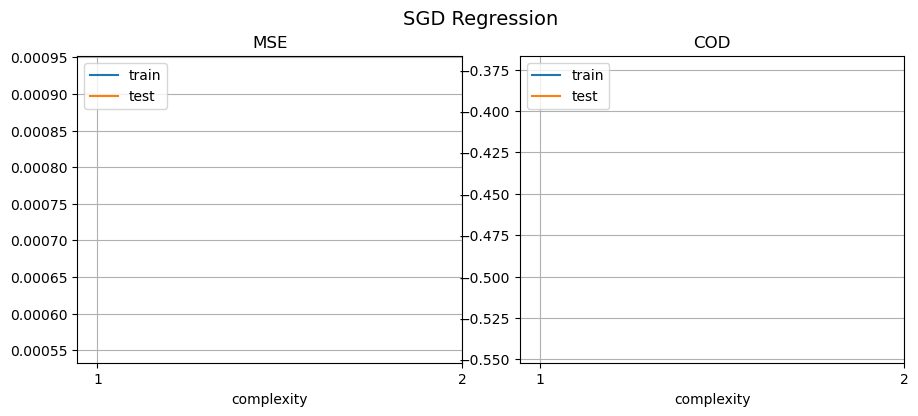

In [146]:
names = tuple(record.keys())
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle('SGD Regression', fontsize=14)
fig.tight_layout(h_pad=2)

axs[0].plot(degrees, record['mse_train'], label='train')
axs[0].plot(degrees, record['mse_test'], label='test')
axs[0].set_title(f"MSE")
axs[0].set_xlabel('complexity')
axs[0].legend(loc='upper left')
axs[0].set_xticks(degrees)
axs[0].grid()

axs[1].plot(degrees, record['cod_train'], label='train')
axs[1].plot(degrees, record['cod_test'], label='test')
axs[1].set_title(f"COD")
axs[1].set_xlabel('complexity')
axs[1].legend(loc='upper left')
axs[1].set_xticks(degrees)
axs[1].grid()

plt.show()

In [ ]:
idx = np.random.choice([*range(5)], size=5, replace=False)
print(x[idx], '\n', y[idx])